### Pytorch Quiz
- CNN을 활용한 모델을 만들어서 정확도 95% 이상의 Classifier를 만드세요
- 코드 수정 가능

In [17]:
from matplotlib import pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### Dataset download

In [18]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
dataloader_train = DataLoader(train_data,
                              batch_size=16,
                              shuffle=True)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)
dataloader_test = DataLoader(test_data,
                              batch_size=16,
                              shuffle=True)

#### Check images

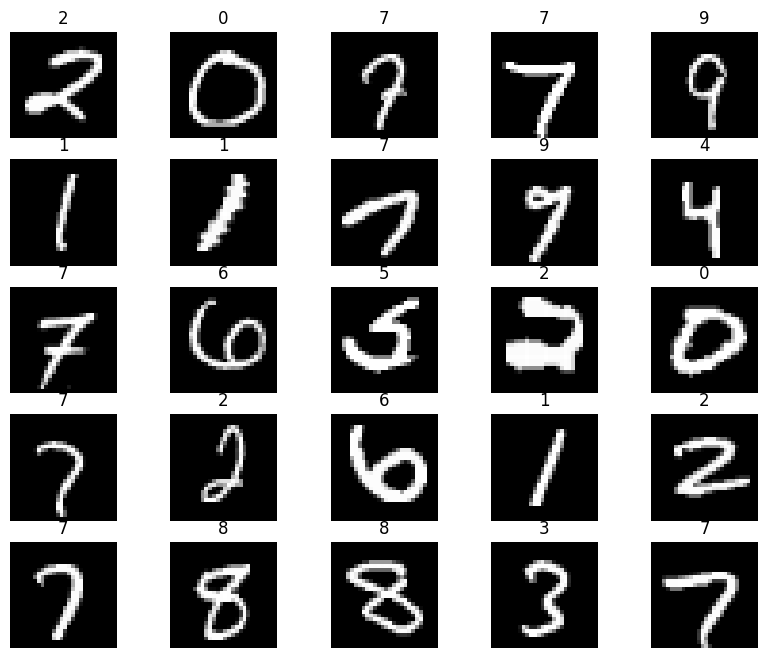

In [19]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### CNN
##### structure
- Convolution 1 : channels 16, kernel size 5, stride 1, padding 2 (output resolution?)
- ReLU
- MaxPool : kernel_size 2, stride 2
- Convlution 2 : channels 32, kernel size 5, stride 1, padding 2 (output resolution?)
- Linear : output channels 10

##### https://pytorch.org/docs/1.12/nn.html

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=16,
                      kernel_size=5,
                      # Conv2d의 stride: 컨볼루션 연산을 수행할 때 필터가 입력 위를 움직이는 간격, stride가 클수록 출력 feature map의 크기가 작아짐
                      stride=1,
                      padding=2),
            nn.ReLU(),
            # MaxPooling의 stride: 맥스풀링 연산을 수행할 때 윈도우가 입력 위를 움직이는 간격을 의미, stride가 클수록 풀링 영역이 겹치지 않고, 출력 feature map의 크기가 작아짐
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.ReLU(),
            # MaxPooling의 stride: 맥스풀링 연산을 수행할 때 윈도우가 입력 위를 움직이는 간격을 의미, stride가 클수록 풀링 영역이 겹치지 않고, 출력 feature map의 크기가 작아짐
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # (W + 2P - K) / S + 1, W=H
        self.out = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

#### Train

In [38]:
cnn = CNN().cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

In [ ]:
# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_train):
        images, labels = images.cuda(), labels.cuda()  # 입력 데이터도 GPU로 이동
        output = cnn(images)
        loss = loss_func(output, labels)

        # clear gradients for this training step
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, loss.item()))

#### Test

In [45]:
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images, labels = images.cuda(), labels.cuda()  # 입력 데이터도 GPU로 이동
        test_output = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        correct += (pred_y == labels).sum().item()
        total += labels.size(0)
    accuracy = correct / total * 100

print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 96.84 Percent
